In [1]:
##Importing all needed libraries
try:
    # Summit-related imports
    import summit
    from summit.benchmarks import ExperimentalEmulator
    from summit.domain import *
    from summit.utils.dataset import DataSet
    from summit.strategies import SOBO, MultitoSingleObjective, LHS

    # External libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # File and path handling
    import pathlib
    import os

except ModuleNotFoundError as e:
    print(f"Error: {e}. Please install the required libraries before running the program.")


In [2]:
# Configurable parameters
base_path = pathlib.Path("F:/Python Programs/MidazTest")
PROJECT_NAME = "MidazTest"
BOUNDS_NAME = f"{PROJECT_NAME}_Bounds.csv"
DATA_NAME = f"{PROJECT_NAME}_Data.csv"
LOG_NAME = f"{PROJECT_NAME}_Log.csv"

# Folder Name
DATA_DIR = "Data"
MODEL_DIR = "Models"
IT_DIR = "IterData"
LOG_DIR = "Logs"

# Function to create directory if it doesn't exist
def create_directory(base_path, directory):
    """Create a directory if it doesn't exist."""
    dir_path = base_path / directory
    if not dir_path.is_dir():
        dir_path.mkdir(parents=True)
        
# Create directories
for directory in [DATA_DIR, MODEL_DIR, IT_DIR, LOG_DIR]:
    create_directory(base_path, directory)

# Set data paths
data_path = base_path / DATA_DIR
model_path = base_path / MODEL_DIR
it_path = base_path / IT_DIR
log_path = base_path / LOG_DIR


# Load initial boundaries data
try:
    init_bounds_df = pd.read_csv(data_path / BOUNDS_NAME)
except FileNotFoundError:
    print(f"Error: File '{BOUNDS_NAME}' not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{BOUNDS_NAME}' is empty or in an invalid format.")


In [3]:
def create_domain(init_bounds_df):
    """
    Create a Summit domain based on the provided boundaries DataFrame.

    Parameters:
    - init_bounds_df (pd.DataFrame): DataFrame containing information about variable boundaries.

    Returns:
    - domain (Domain): The created Summit domain.
    - obj_df (pd.DataFrame): DataFrame for objective variables.
    - in_count (int): Count of input variables.
    - out_count (int): Count of output variables.
    """
    if not isinstance(init_bounds_df, pd.DataFrame) or init_bounds_df.empty:
        raise ValueError("Invalid input: init_bounds_df must be a non-empty DataFrame.")
        
    domain = Domain()
    obj_df = pd.DataFrame()
    obj_df = DataSet.from_df(obj_df)

    in_count = 0
    out_count = 0

    for idx, row in init_bounds_df.iterrows():
        name = row[0]
        description = row[5]
        data_type = row[1]

        if data_type == 'Categorical':
            levels = row[2].split(',')

            domain += CategoricalVariable(
                name = name,
                description = description,
                levels = levels
            )
            in_count += 1

        elif data_type == 'Continuous':
            bounds = [row[3], row[4]]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds
            )
            in_count += 1

        elif data_type == 'Objective':
            bounds = [row[3], row[4]]
            maximize = row[6]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds,
                is_objective = True,
                maximize = maximize
            )
            out_count += 1

            obj_df[(name, "DATA")] = ""
        
    return domain, obj_df, in_count, out_count


In [4]:
data_df = DataSet.read_csv(data_path / DATA_NAME) 
domain, obj_df, in_count, out_count = create_domain(init_bounds_df)

In [5]:
data_df

,Temperature,Catalyst_Amount,Starting_Reagent,Solvent,Time,Base,strategy,Main_Product,Main_Impurity
,DATA,DATA,DATA,DATA,DATA,DATA,METADATA,DATA,DATA
0,50.0,1.1045,1.415,0.32,5.3,1.6,LHS,0.078,0.0
1,62.0,1.3035,1.685,0.2,14.1,2.4,LHS,0.561,0.0
2,58.0,0.1095,1.235,0.44,16.3,1.2,LHS,0.0,0.012
3,74.0,0.7065,1.145,0.12,18.5,4.0,LHS,0.383,0.0
4,42.0,1.5025,1.955,0.36,20.7,4.4,LHS,0.381,0.0
5,54.0,1.7015,1.325,0.24,3.1,4.8,LHS,0.318,0.0
6,66.0,0.9055,1.775,0.28,11.9,2.8,LHS,0.376,0.05
7,46.0,1.9005,1.505,0.4,9.7,3.6,LHS,0.25,0.0
8,70.0,0.5075,1.595,0.48,7.5,2.0,LHS,0.055,0.009


In [6]:
domain

Name,Type,Description,Values
Temperature,"continuous, input",Reaction temperature in degrees Celsius (ºC),"[40.0,80.0]"
Catalyst_Amount,"continuous, input",Catalyst amounts in molar equivalents (Equiv.),"[0.01,2.0]"
Starting_Reagent,"continuous, input",2-Methylimidozole amounts in molar equivalents (Equiv.),"[1.1,2.0]"
Solvent,"continuous, input",Solvent amount in milliliters (mL),"[0.1,0.35]"
Time,"continuous, input",Duration of reaction in hours (hr),"[2.0,24.0]"
Base,"continuous, input",Base amount in molar equivalents (Equiv.),"[1.0,5.0]"
Main_Product,"continuous, maximize objective",LCAP of Main Product,"[0.0,1.0]"
Main_Impurity,"continuous, minimize objective",LCAP of Main Impurity,"[0.0,1.0]"


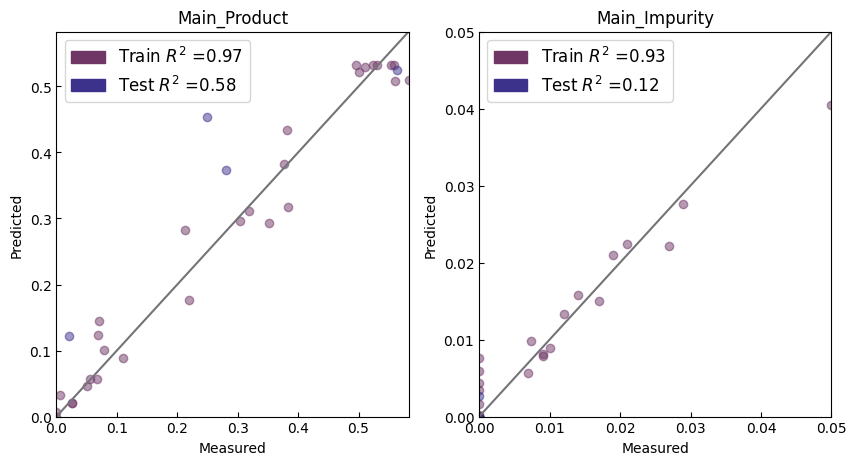

In [11]:
test_size = 0.1
exp_num = 10
cv_fold = exp_num - test_size*exp_num

emul = ExperimentalEmulator(
    model_name = PROJECT_NAME,
    domain = domain,
    dataset = data_df
)

emul.train(
    max_epochs = 10000,
    cv_fold = cv_fold,
    random_state = 410,
    test_size = test_size,
    verbose = 0
)

fig, ax = emul.parity_plot(include_test=True)

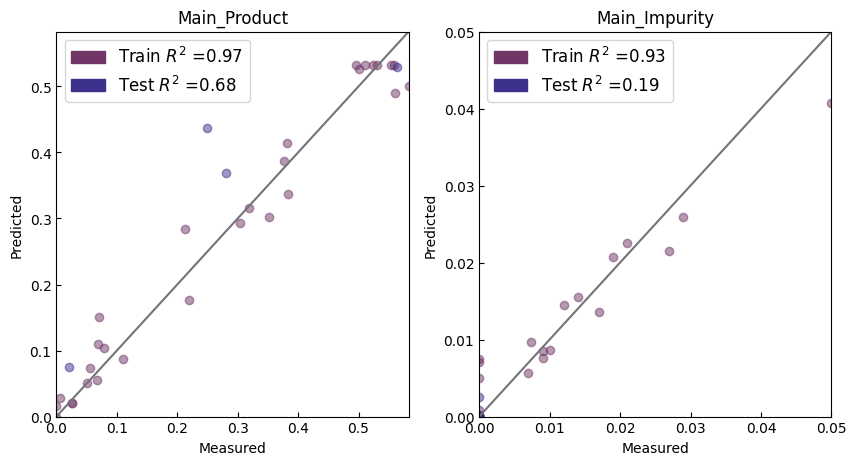

In [10]:
test_size = 0.1
exp_num = 10
cv_fold = exp_num - test_size*exp_num

emul = ExperimentalEmulator(
    model_name = PROJECT_NAME,
    domain = domain,
    dataset = data_df
)

emul.train(
    max_epochs = 5000,
    cv_fold = cv_fold,
    random_state = 410,
    test_size = test_size,
    verbose = 0
)

fig, ax = emul.parity_plot(include_test=True)

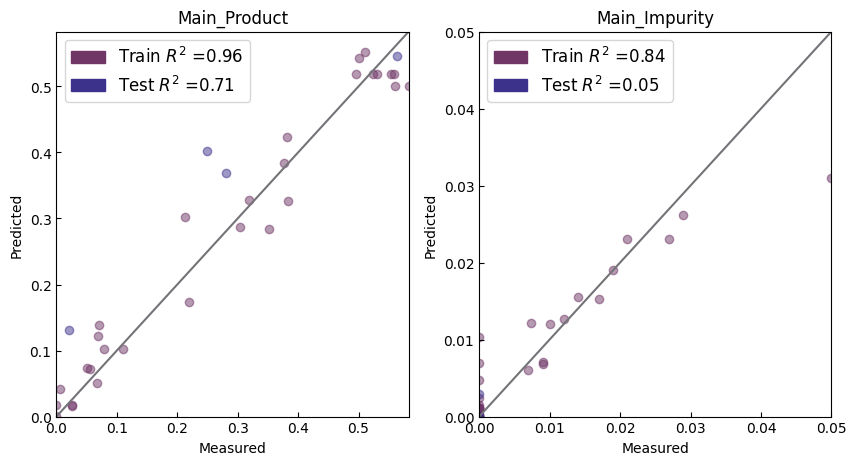

In [9]:
test_size = 0.1
exp_num = 33
cv_fold = exp_num - test_size*exp_num

emul = ExperimentalEmulator(
    model_name = PROJECT_NAME,
    domain = domain,
    dataset = data_df
)

emul.train(
    max_epochs = 1000,
    cv_fold = cv_fold,
    random_state = 410,
    test_size = test_size,
    verbose = 0
)

fig, ax = emul.parity_plot(include_test=True)